# Installing Dependencies

In [1]:
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg
!pip install seaborn
import seaborn as sns
import re

!pip install keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array

# Extract Data From Google Colab

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
local_zip = '/content/drive/MyDrive/data2.zip'
with zipfile.ZipFile(local_zip, "r") as zip_ref:
  zip_ref.extractall()

local_zip2 = '/content/drive/MyDrive/test_data2.zip'
with zipfile.ZipFile(local_zip2, "r") as zip_ref:
  zip_ref.extractall()

In [3]:
local_zip_train = "C:/Users/User/Documents/VS/python/capstone/ML-Capstone/data2.zip"
with zipfile.ZipFile(local_zip_train, "r") as zip_ref_train:
    zip_ref_train.extractall()

local_zip_val = "C:/Users/User/Documents/VS/python/capstone/ML-Capstone/test_data2.zip"
with zipfile.ZipFile(local_zip_val, "r") as zip_ref_val:
    zip_ref_val.extractall()

First we will check how many images that we have to train the model. This code below will go through all the files from the directory and count the number of images.

In [7]:
def check_total_data(base_dir):
    for root, dirs, files in os.walk(base_dir):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            folder_count = sum([1 for file in os.listdir(folder_path) if file.endswith('.jpg') or file.endswith('.jpeg')])
            print(f"Total training {folder}: {folder_count}")

In [11]:
train_dir = "C:/Users/User/Documents/VS/python/capstone/ML-Capstone/train/"
check_total_data(train_dir)

Total training apel: 120
Total training ayam_goreng: 120
Total training bakso: 120
Total training bakwan: 120
Total training batagor: 120
Total training beberuk: 120
Total training bubur: 120
Total training burger: 120
Total training cakwe: 120
Total training capcay: 120
Total training crepes: 120
Total training donat: 120
Total training eskrim: 120
Total training gudeg: 120
Total training gulai_ikan: 120
Total training ikan_goreng: 120
Total training jeruk: 120
Total training kebab: 120
Total training kentang_goreng: 120
Total training kerak_telor: 120
Total training nasi_kuning: 120
Total training nasi_pecel: 120
Total training papeda: 120
Total training rendang: 120
Total training tahu_sumedang: 120


In [12]:
val_dir = "C:/Users/User/Documents/VS/python/capstone/ML-Capstone/val/"
check_total_data(val_dir)

Total training apel: 20
Total training ayam_goreng: 22
Total training bakso: 20
Total training bakwan: 20
Total training batagor: 20
Total training beberuk: 20
Total training bubur: 20
Total training burger: 20
Total training cakwe: 20
Total training capcay: 20
Total training crepes: 20
Total training donat: 20
Total training eskrim: 20
Total training gudeg: 20
Total training gulai_ikan: 20
Total training ikan_goreng: 20
Total training jeruk: 20
Total training kebab: 20
Total training kentang_goreng: 20
Total training kerak_telor: 20
Total training nasi_kuning: 20
Total training nasi_pecel: 20
Total training papeda: 20
Total training rendang: 20
Total training tahu_sumedang: 20


# Simple visualization for data distribution

In [14]:
categories = {0: "apel", 
              1: "ayam_goreng", 
              2: "bakso", 
              3: "bakwan", 
              4: "batagor", 
              5: "beberuk", 
              6: "bubur", 
              7: "burger", 
              8: "cakwe", 
              9: "capcay", 
             10: "crepes", 
             11: "donat", 
             12: "eskrim", 
             13: "gudeg", 
             14: "gulai_ikan", 
             15: "ikan_goreng", 
             16: "jeruk",
             17: "kebab",
             18: "kentang_goreng", 
             19: "kerak_telor", 
             20: "nasi_kuning",
             21: "nasi_pecel",
             22: "papeda",
             23: "rendang", 
             24: "tahu_sumedang"}

In [18]:
import re
# Add class name prefix to filename. For example "/bakso1.jpg" become "bakso/bakso1.jpg"
def add_ClassName_prefix(df, column):
    df[column] = df[column].apply(lambda x: x[:re.search("\d", x).start()] + '/' + x if re.search("\d", x) else x)
    return df

# List containing all file names and categories in the dataset
def create_dataframe(base_dir):
    list_filenames = []
    list_categories = []

    for category in categories:
        filenames = os.listdir(base_dir + categories[category])
        list_filenames += filenames
        list_categories = list_categories + [category] * len(filenames)

    df = pd.DataFrame({
        "file_name": list_filenames,
        "category": list_categories
    })
    return df

df_train = add_ClassName_prefix(create_dataframe(train_dir), "file_name")


print(f"Number of elements in data train: {len(df_train)}")

Number of elements in data train: 3000


In [19]:
df_val = add_ClassName_prefix(create_dataframe(val_dir), "file_name")
print(f"Number of elements in data val: {len(df_val)}")

Number of elements in data val: 502


Text(0.5, 1.0, 'Count of Images Train per Class')

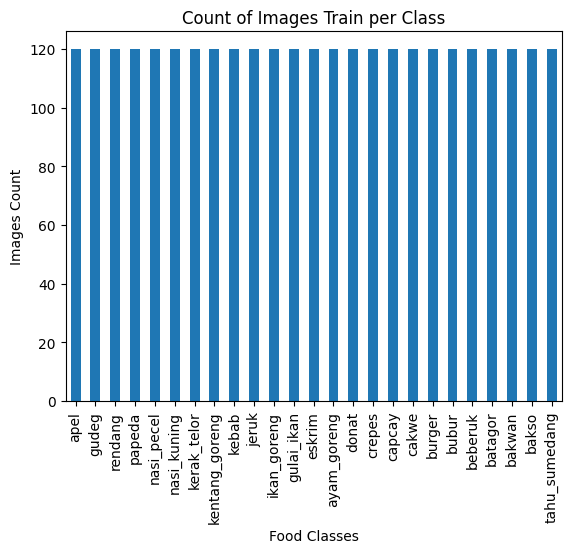

In [20]:
df_train_visualize = df_train.copy()

# Change category from number to name
df_train_visualize.category = df_train_visualize.category.apply(lambda x: categories[x])
df_train_visualize.category.value_counts().plot.bar(x="count", y="category")

plt.xlabel("Food Classes")
plt.ylabel("Images Count")
plt.title("Count of Images Train per Class")

Text(0.5, 1.0, 'Count of Images Validation per Class')

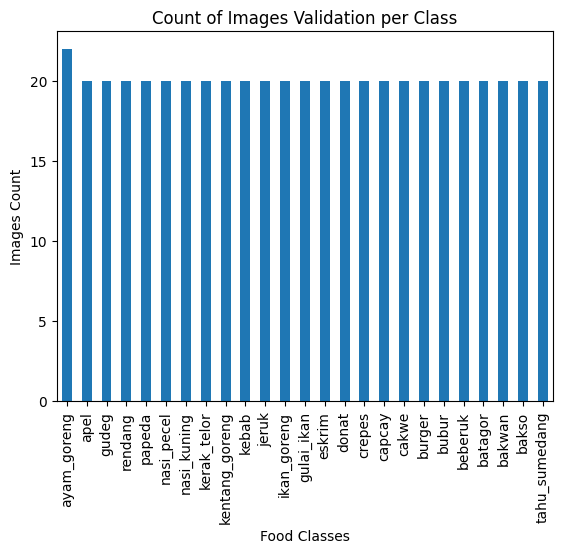

In [21]:
df_val_visualize = df_val.copy()

# Change category from number to name
df_val_visualize.category = df_val_visualize.category.apply(lambda x: categories[x])
df_val_visualize.category.value_counts().plot.bar(x="count", y="category")

plt.xlabel("Food Classes")
plt.ylabel("Images Count")
plt.title("Count of Images Validation per Class")

# Create the model

Using pre-trained model (inception v3) we are now will create the model for food image classification

In [47]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-11 06:14:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.96.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  27.8MB/s    in 3.0s    

2023-06-11 06:14:16 (27.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [48]:
# Set the weights file that we downloaded into a variable
local_weights = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
inception_v3 = InceptionV3(input_shape = (150, 150, 3), 
                           include_top = False, 
                           weights = None)

# Load the pre-trained weights we downloaded.
inception_v3.load_weights(local_weights)

# Freeze the weights of the layers.
for layer in inception_v3.layers:
  layer.trainable = False

In [49]:
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [50]:
# Choose `mixed_7` as the last layer of our base model
last_layer = inception_v3.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [51]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(25, activation='softmax')(x)           

model = Model(inception_v3.input, x) 

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [52]:
# Set the training parameters
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# Image Data Generators for Training and Validation
In this code snippet, we create image data generators for both training and validation datasets. These generators will perform real-time data augmentation and preprocessing, which helps improve the model's performance and generalization.

## Training Data Generator
The train_datagen object is an instance of the ImageDataGenerator class, which applies various transformations to the training images. These transformations include rotation, shifting, shearing, zooming, and horizontal flipping. The pixel values of the images are also rescaled to a range of [0, 1] using the rescale parameter.

The train_generator is created using the flow_from_directory method of the ImageDataGenerator class. It generates batches of augmented images and their corresponding labels from the train_dir directory. The images are resized to a target size of (150, 150), and the labels are encoded in categorical format.

## Validation Data Generator
Similar to the training data generator, the val_datagen object is created using the ImageDataGenerator class. However, it only performs pixel rescaling with a rescale factor of 1/255, without applying any other transformations.

The validation_generator is created using the flow_from_directory method, generating batches of validation images and labels from the val_dir directory. The images are also resized to a target size of (150, 150) and the labels are encoded categorically.

In [54]:
train_dir = "/content/train"
val_dir = "/content/val"
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

validation_generator =  val_datagen.flow_from_directory(val_dir,
                                                        class_mode  = 'categorical', 
                                                        target_size = (150, 150))

Found 3000 images belonging to 25 classes.
Found 502 images belonging to 25 classes.


Now we train our model with the 50 epochs

In [55]:
# Train the model.
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,)

Epoch 1/50
94/94 [==============================] - 89s 885ms/step - loss: 2.4533 - accuracy: 0.4187 - val_loss: 1.0255 - val_accuracy: 0.6733
Epoch 2/50
94/94 [==============================] - 83s 884ms/step - loss: 1.1707 - accuracy: 0.6347 - val_loss: 0.8830 - val_accuracy: 0.7191
Epoch 3/50
94/94 [==============================] - 84s 892ms/step - loss: 0.9860 - accuracy: 0.6960 - val_loss: 0.8514 - val_accuracy: 0.7331
Epoch 4/50
94/94 [==============================] - 82s 872ms/step - loss: 0.8130 - accuracy: 0.7557 - val_loss: 0.7094 - val_accuracy: 0.7749
Epoch 5/50
94/94 [==============================] - 82s 872ms/step - loss: 0.7622 - accuracy: 0.7630 - val_loss: 0.6670 - val_accuracy: 0.7769
Epoch 6/50
94/94 [==============================] - 80s 850ms/step - loss: 0.6591 - accuracy: 0.7883 - val_loss: 0.7243 - val_accuracy: 0.7829
Epoch 7/50
94/94 [==============================] - 83s 888ms/step - loss: 0.6013 - accuracy: 0.8160 - val_loss: 0.6748 - val_accuracy: 0.7908

After we build our model we want to know how good our model is, so in this code below we use matplotlib to visualize our model accuracy

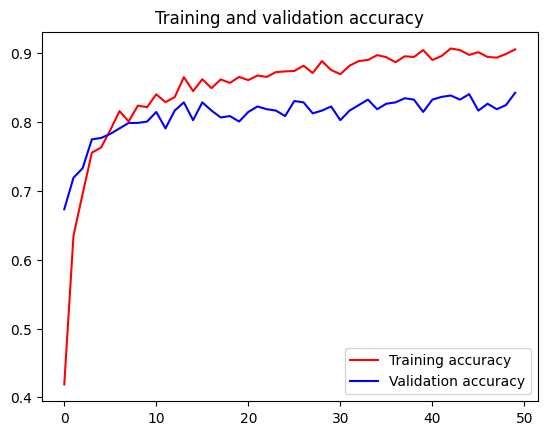

<Figure size 640x480 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

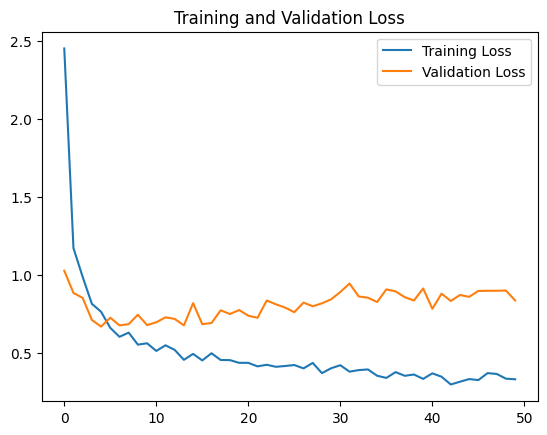

<Figure size 640x480 with 0 Axes>

In [57]:
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend(loc=0)
plt.figure()

plt.show()

# Check Accuracy

In [4]:
folder_path = "C:/Users/User/Documents/VS/python/capstone/ML-Capstone/val_data"
file_list = os.listdir(folder_path)
predicted_labels = []
for fn in file_list:
    file_path = os.path.join(folder_path, fn)
    img = load_img(file_path, target_size=(150, 150))
    image_to_array = img_to_array(img)
    expanded_image = np.expand_dims(image_to_array, axis=0)
    expanded_image /= 255
    classes = model.predict(expanded_image)
    predicted_labels.append(np.argmax(classes))

1/1 [==============================] - 0s 52ms/step


In [5]:
import sklearn.metrics as metrics
from prettytable import PrettyTable

# Calculate precision
precision = metrics.precision_score(validation_generator.classes, predicted_labels, average='macro')

# Calculate recall
recall = metrics.recall_score(validation_generator.classes, predicted_labels, average='macro')

# Calculate accuracy
accuracy = metrics.accuracy_score(validation_generator.classes, predicted_labels)

# Calculate F1-score
f1_score = metrics.f1_score(validation_generator.classes, predicted_labels, average='macro')

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Metric", "Score"]

# Add rows to the table
table.add_row(["Precision", precision])
table.add_row(["Recall", recall])
table.add_row(["Accuracy", accuracy])
table.add_row(["F1-Score", f1_score])

# Print the table
print(table)


+-----------+--------------------+
|   Metric  |       Score        |
+-----------+--------------------+
| Precision | 0.8518007014881291 |
|   Recall  | 0.8430909090909091 |
|  Accuracy | 0.8426294820717132 |
|  F1-Score | 0.8410923184923734 |
+-----------+--------------------+


Now we define categories dictionary. The categories dictionary is used to associate food item names with the predicted labels obtained from a model. Each key in the dictionary represents a label, and the corresponding value is the name of the food item associated with that label. By using this dictionary, we can easily map the predicted labels to their respective food item names, providing a more intuitive and meaningful interpretation of the model's predictions.

In [6]:
categories = {0: "apel", 
              1: "ayam_goreng", 
              2: "bakso", 
              3: "bakwan", 
              4: "batagor", 
              5: "beberuk_terong", 
              6: "bubur", 
              7: "burger", 
              8: "cakwe", 
              9: "capcay", 
             10: "crepes", 
             11: "donat", 
             12: "eskrim", 
             13: "gudeg", 
             14: "gulai_ikan", 
             15: "ikan_goreng", 
             16: "jeruk",
             17: "kebab",
             18: "kentang_goreng", 
             19: "kerak_telor", 
             20: "nasi_kuning",
             21: "nasi_pecel",
             22: "papeda",
             23: "rendang", 
             24: "tahu_sumedang"}

Now we check our model to predict the data that has never been seen before.

In [59]:
folder_path = "/content/test"
file_list = os.listdir(folder_path)
for fn in file_list:
    file_path = os.path.join(folder_path, fn)
    img = load_img(file_path, target_size=(150, 150))
    image_to_array = img_to_array(img)
    expanded_image = np.expand_dims(image_to_array, axis=0)
    expanded_image /= 255
    classes = model.predict(expanded_image)
    print(file_path)
    print(categories[np.argmax(classes)])

1/1 [==============================] - 2s 2s/step
/content/test/batagor2.jpg
batagor
1/1 [==============================] - 0s 28ms/step
/content/test/kerak_telor0.jpg
kerak_telor
1/1 [==============================] - 0s 27ms/step
/content/test/kebab3.jpg
kebab
1/1 [==============================] - 0s 26ms/step
/content/test/bakwan3.jpg
bakwan
1/1 [==============================] - 0s 27ms/step
/content/test/rendang4.jpg
rendang
1/1 [==============================] - 0s 27ms/step
/content/test/rendang2.jpg
rendang
1/1 [==============================] - 0s 27ms/step
/content/test/ikan_goreng3.jpg
ikan_goreng
1/1 [==============================] - 0s 27ms/step
/content/test/crepes2.jpg
crepes
1/1 [==============================] - 0s 28ms/step
/content/test/eskrim0.jpg
eskrim
1/1 [==============================] - 0s 28ms/step
/content/test/batagor4.jpg
batagor
1/1 [==============================] - 0s 27ms/step
/content/test/gulai_ikan2.jpg
rendang
1/1 [==============================]

# Save the model
After we train our model, we want to save our model so we can use it later. We save it in the .h5 format


In [60]:
model.save("klasifikasi_makanan2.h5")

In [ ]:
!ls klasifikasi_makanan2.h5

model_HDF5_format.h5
